### Loading MNIST data as spiketrains

The following function will load the MNIST dataset using torchvision modules. It'll download an pre-pre-process the data for faster usage.

In [16]:
gen_train = dclllib.get_mnist_loader(100, train=True)
gen_test = dclllib.get_mnist_loader(100, train=False)

Pre-processing dataset: 100%|██████████| 10000/10000 [00:00<00:00, 11696.05it/s]


Because MNIST is an image, we need to transform it into a spiketrain. The function image2spiketrain takes case of this.

In [28]:
datait = iter(gen_train)
raw_input, raw_labels = next(datait)
data, labels1h = dclllib.image2spiketrain(raw_input, raw_labels, max_duration=1000, gain=100)
data_t = torch.FloatTensor(data)
labels_t = torch.Tensor(labels1h)

Let's examine the shape of data:

In [ ]:
data.shape

1000 here corresponds to the number of time setps, 100 is the batchsize, 1 is the number of channels and 28,28 are the height and width, respectively. The last three dimensions will important when we'll use convolutional or locally connected layers, but for the moment, our network has no structure,, so we will flatten them.

Here is what one sample looks like

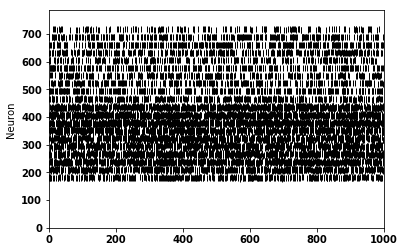

(<matplotlib.axes._subplots.AxesSubplot at 0x7fa23ada3898>, None)

In [33]:
dclllib.plotLIF(U=None,S=data_t[:,0].view(1000,-1).data.numpy())

The average reate here is more revealing. Our MNIST input spike trains are simply flattened spiketrains representing the digit image in the firing rates.

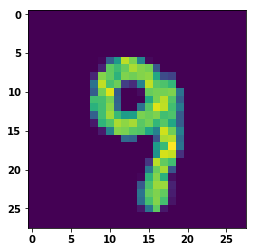

In [36]:
plt.imshow(data_t[:,0].data.numpy().mean(axis=0).reshape(28,28))

Let's create a function that does all these steps:

In [37]:
def next_mnist_batch(datait, batchsize=100, T=1000, max_rate = 100):
    raw_input, raw_labels = next(datait)
    data, labels1h = dclllib.image2spiketrain(raw_input, raw_labels, max_duration=T, gain=max_rate)
    data_t = torch.FloatTensor(data).view(T,batchsize,-1)
    labels_t = torch.Tensor(labels1h)
    return data_t, labels_t  